# Elastic Perfectly-Plastic - Explicit Integration

## Define Model

#### i. Elastic stress-strain relationship  
$\dot{\sigma} = E\left(\dot{\varepsilon} - \dot{\varepsilon}^p\right)$  

#### ii. Hardening variables  
$\sigma_y$ = Yield stress

#### iii. Yield Surface  

$f(\sigma,\sigma_y) = |\sigma| - \sigma_y$

#### iv. Flow rule  

$\dot{\varepsilon}^p = \gamma \cdot sign\left(\sigma\right)$

#### v. Hardening Law  

$\dot{\sigma_y} = 0$

#### vi. Karush-Kuhn-Tucker complementary conditions  

$\gamma \geq 0$  

$f\left(\sigma, \sigma_y\right) \leq 0$  

$\gamma \cdot f\left(\sigma, \sigma_y\right)=0$  

#### vii. Consistency condition  

$\gamma \cdot \dot{f}\left(\sigma, \sigma_y\right) = 0$  

## Implicit Implementation (Return Mapping)

$\sigma_{i}$ = stress value at start of current load step  

$\Delta \varepsilon$ = strain increment  

$\sigma_{i+1}^{trial} = \sigma_{i} + E \cdot \Delta \varepsilon$  

$f_{i+1}^{trial} = \left|\sigma_{i+1}^{trial}\right| - \sigma_y$  

if $f_{i+1}^{trial} < 0$:

> $\sigma_{i+1} = \sigma_{i+1}^{trial}$

> $\varepsilon^p_{i+1} = \varepsilon^p_i$  

else:

> $\Delta \gamma = \frac{f_{i+1}^{trial}}{E}$  

> $\sigma_{i+1} = \sigma_{i+1}^{trial} - \Delta \gamma \cdot E \cdot sign \left(\sigma_{i+1}^{trial}\right)$  

> $\varepsilon^p_{i+1} = \varepsilon^p_i + \Delta \gamma \cdot sign \left(\sigma_{i+1}^{trial}\right)$

## Explicit Implementation

initialize model at time step 0:  

$\Delta\epsilon^p = 0.0$


Now loop over time steps, starting from index 1, where index 0 is the initial condition of the model

$\sigma_{i+1} = \sigma_{i} + E\left(\Delta_\epsilon - \Delta_\epsilon^p\right)$  

$f = \left|\sigma_{i+1}\right| - \sigma_y$  

if f < 0:

> $\Delta\epsilon^p = 0.0$  

else:

> $\Delta\gamma = \frac{f}{E}$  

> $\Delta\epsilon_p = \Delta\gamma sign\left(\Delta \epsilon\right)$  


<IPython.core.display.Javascript object>


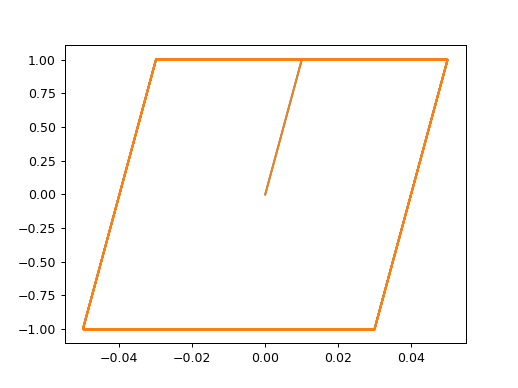

In [28]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

E = 100
sigmay = 1
epsilon_y = sigmay/E
Npts = 10000 # Number of points per cycle in sinusoidal strain history
Ncyc = 3 # Number of cycles in sinusoidal strain history
N = Npts*Ncyc
time = np.arange(0,N)
epsilon_max = 5.0*epsilon_y
epsilon = epsilon_max*np.sin(2.0*np.pi*time/Npts)

# Now define stress
sigma = np.zeros(N)
for i in range(1,N):
    depsilon = epsilon[i] - epsilon[i-1]
    sigma_trial = sigma[i-1] + E*depsilon
    ftrial = np.abs(sigma_trial) - sigmay
    if(ftrial<0):
        sigma[i] = sigma_trial
    else:
        delta_gamma = ftrial/E
        sigma[i] = sigma_trial - delta_gamma*E*np.sign(sigma_trial)
        
        
# Implement explicit model
sigma_ex = np.zeros(N)
epsilon_p_ex = np.zeros(N)
depsilon_p = 0
for i in range(1,N):
    depsilon = epsilon[i] - epsilon[i-1]
    sigma_ex[i] = sigma_ex[i-1] + E*(depsilon - depsilon_p)
    f = np.abs(sigma_ex[i-1]) - sigmay
    if(f<0):
        epsilon_p_ex[i] = epsilon_p_ex[i-1]
        depsilon_p = 0.0
    else:
        dgamma = f/E
        depsilon_p = dgamma*np.sign(depsilon)
        epsilon_p_ex[i] = epsilon_p_ex[i-1] + depsilon_p
        
plt.plot(epsilon,sigma)
plt.plot(epsilon,sigma_ex)

<IPython.core.display.Javascript object>


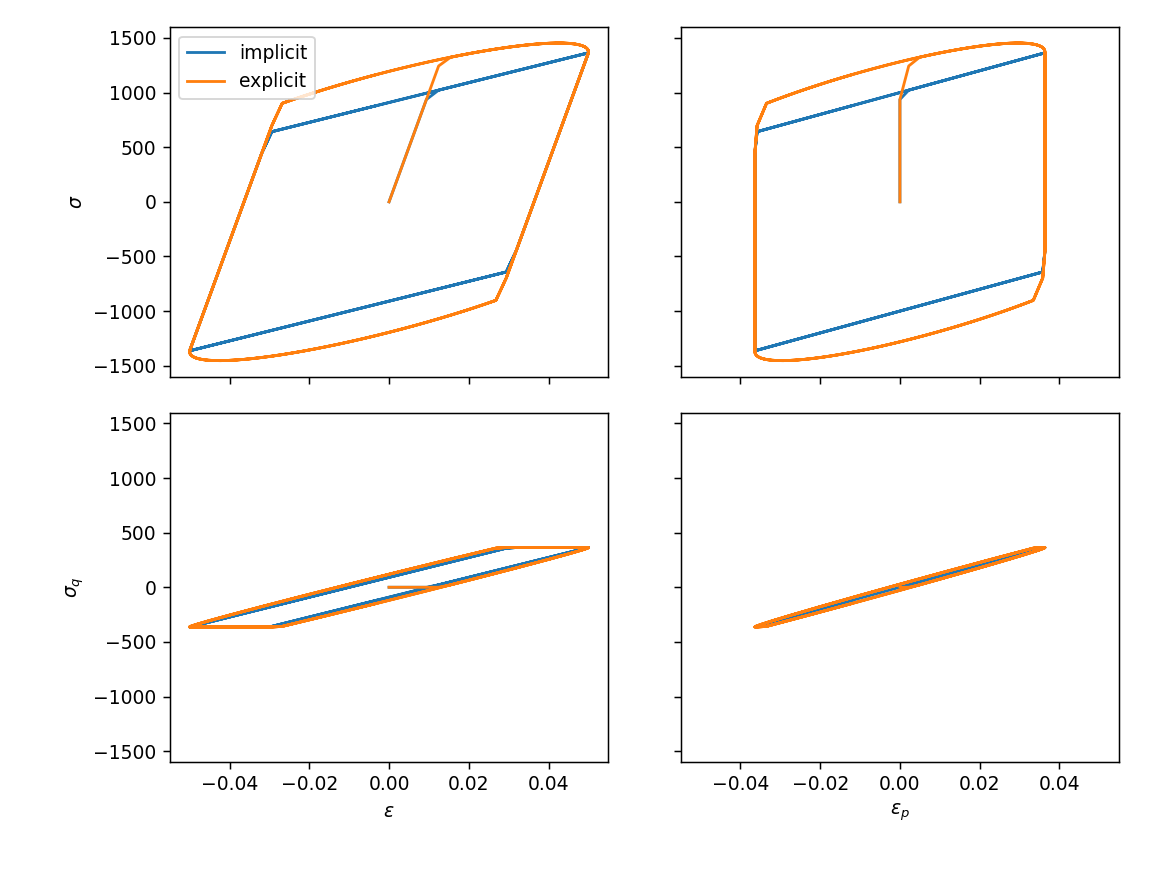

In [26]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

E = 100000
H = 0.1*E
sigmay = 1000
epsilon_y = sigmay/E
Npts = 100 # Number of points per cycle in sinusoidal strain history
Ncyc = 3 # Number of cycles in sinusoidal strain history
N = Npts*Ncyc
time = np.arange(0,N)
epsilon_max = 5.0*epsilon_y
epsilon = epsilon_max*np.sin(2.0*np.pi*time/Npts)

# Now define stress
sigma = np.zeros(N)
sigma_q = np.zeros(N)
epsilon_p = np.zeros(N)
for i in range(1,N):
    depsilon = epsilon[i] - epsilon[i-1]
    sigma_trial = sigma[i-1] + E*depsilon
    sigma_qtrial = sigma_q[i-1]
    ftrial = np.abs(sigma_trial-sigma_qtrial) - sigmay
    if(ftrial<0):
        sigma[i] = sigma_trial
        sigma_q[i] = sigma_qtrial
        epsilon_p[i] = epsilon_p[i-1]
    else:
        delta_gamma = ftrial/(E+H)
        sigma[i] = sigma_trial - delta_gamma*E*np.sign(sigma_trial-sigma_qtrial)
        sigma_q[i] = sigma_q[i-1] + delta_gamma*H*np.sign(sigma_trial-sigma_qtrial)
        epsilon_p[i] = epsilon_p[i-1] + delta_gamma*np.sign(sigma_trial-sigma_qtrial)
        
        
# Explicit implementation
sigma_ex = np.zeros(N)
sigma_q_ex = np.zeros(N)
epsilon_p_ex = np.zeros(N)
depsilon_p_ex = 0.0
for i in range(1,N):
    depsilon = epsilon[i] - epsilon[i-1]
    sigma_ex[i] = sigma_ex[i-1] + E*(depsilon-depsilon_p_ex)
    sigma_q_ex[i] = sigma_q_ex[i-1] + H*depsilon_p_ex
    f = np.abs(sigma_ex[i] - sigma_q_ex[i]) - sigmay
    if(f<=0):
        depsilon_p_ex = 0.0
        epsilon_p_ex[i] = epsilon_p_ex[i-1]
    else:
        dgamma = f/(E+H)
        depsilon_p_ex = dgamma*np.sign(depsilon)
        epsilon_p_ex[i] = epsilon_p_ex[i-1] + depsilon_p_ex
        
fig, ax = plt.subplots(2,2,sharex='all',sharey='all')
ax[0,0].plot(epsilon,sigma,label='implicit')
ax[0,1].plot(epsilon_p, sigma)
ax[1,0].plot(epsilon,sigma_q)
ax[1,1].plot(epsilon_p,sigma_q)
ax[0,0].plot(epsilon,sigma_ex,label='explicit')
ax[0,1].plot(epsilon_p_ex, sigma_ex)
ax[1,0].plot(epsilon,sigma_q_ex)
ax[1,1].plot(epsilon_p_ex,sigma_q_ex)
ax[1,0].set_xlabel(r'$\epsilon$')
ax[0,0].set_ylabel(r'$\sigma$')
ax[1,0].set_ylabel(r'$\sigma_q$')
ax[1,1].set_xlabel(r'$\epsilon_p$')
ax[0,0].legend()
plt.tight_layout()